**OCT image segmentation**

*   Optimizer - AdaBound
*   Loss - sparse categorical crossentropy
*   image resolution 512x256,
*   Batch size = 4
*   6 fold cross validation

---
**Models**
1.   vanilla U-net
2.   Att U-net

---
**Data augmentation**

*   horizontal flip
*   rotate (angle in range (-8, 8))



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
### importing packages
import os
import glob

import numpy as np
import pandas as pd

import cv2

import PIL
from PIL import Image
from PIL import ImageOps

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras import layers
from keras.layers import *
from keras.models import *
from keras import regularizers, optimizers
from keras.regularizers import l2
from keras.optimizers import *
from keras.utils import *
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint


from skimage.transform import resize
from scipy.ndimage import rotate
from scipy import ndimage, misc

from IPython.display import Image, display

import random
seed = 13
np.random.seed = seed

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
print(tf.__version__)

2.17.1


In [ ]:
IMG_WIDTH_ORIGINAL=512
IMG_HEIGHT_ORIGINAL=1024
IMG_WIDTH = 256
IMG_HEIGHT = 512
IMG_CHANNELS = 1 # grayscale images
img_size = (IMG_HEIGHT, IMG_WIDTH)
num_classes = 8 #8 in case just fluids is 4, in case fluids and layers is 8
batch_size = 4 # try 4, 8, 12, 16, 32


# paths to image folders
train_img_path='/content/drive/MyDrive/Colab Notebooks/AROI/6FCV/3case/train/raw'
train_mask_path='/content/drive/MyDrive/Colab Notebooks/AROI/6FCV/3case/train/mask/'


### FOR TESTING
val_img_path='/content/drive/MyDrive/Colab Notebooks/AROI/LOOCV/12F/test/raw'
val_mask_path='/content/drive/MyDrive/Colab Notebooks/AROI/LOOCV/12F/test/mask'


**Prepare paths of input images and target segmentation masks**

In [ ]:
input_img_paths = sorted(
    [
        os.path.join(train_img_path, fname)
        for fname in os.listdir(train_img_path)
        if fname.endswith(".png")
    ]
)

target_img_paths = sorted(
    [
        os.path.join(train_mask_path, fname)
        for fname in os.listdir(train_mask_path)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)
print("Number of training samples:", len(input_img_paths))

Number of training samples: 936


**Displaying images and masks - check**


In [ ]:
# colour definition
black = np.array([0, 0, 0, 255])
white = np.array([255, 255, 255, 255])
yellow = np.array([255, 255, 0, 255])
red = np.array([255, 0, 0, 255])
blue = np.array([0, 0, 255, 255])
light_blue = np.array([0, 255, 255, 255])
green = np.array([0, 255, 0, 255])
pink = np.array([255, 0, 255, 255])

# function which trasform mask values 0,1,2,3,4,5,6,7 into colours
def num_to_colors (mask, height, width):
    col_mask = np.zeros((height, width, 4))
    for j in range (0,width):
        for i in range (0,height):
            if (mask[i,j]==0):
                col_mask[i,j]=black
            elif (mask[i,j]==1):
                col_mask[i,j]= red
            elif (mask[i,j]==2):
                col_mask[i,j]= yellow
            elif (mask[i,j]==3):
                col_mask[i,j]= white
            elif (mask[i,j]==4):
                col_mask[i,j]= blue
            elif (mask[i,j]==5):
                col_mask[i,j]=light_blue
            elif (mask[i,j]==6):
                col_mask[i,j]=pink
            elif (mask[i,j]==7):
                col_mask[i,j]=green

    return col_mask

Image id: 15 patient15_raw0029.png



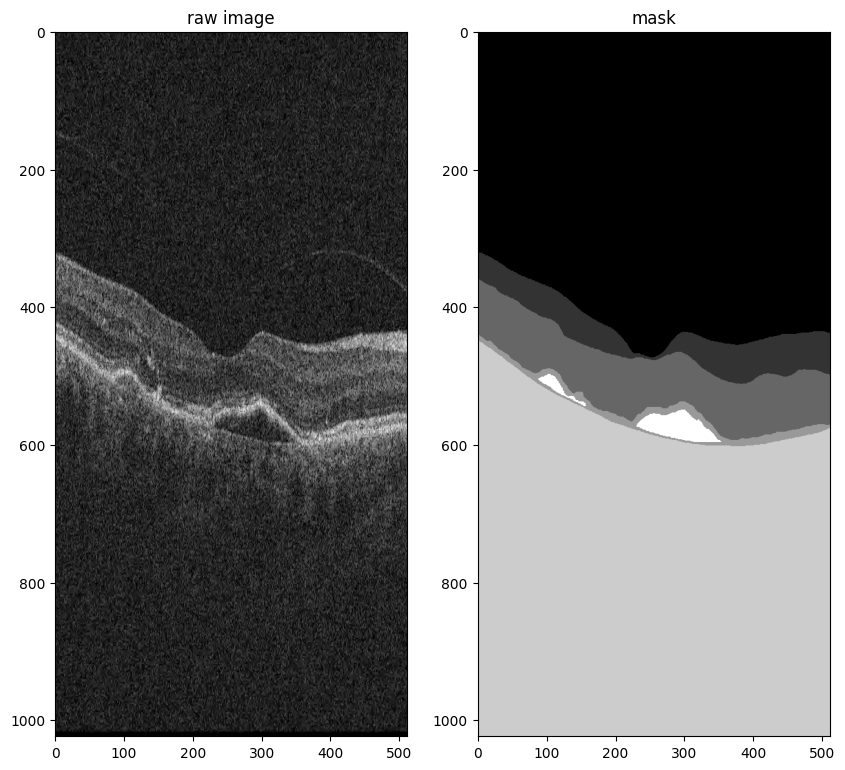

(array([645534,      0,  64806,      0, 122538,      0,  18972,      0,
       709236,  11778]), array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
       229.5, 255. ]))


In [ ]:
m=os.listdir(train_img_path)
#i = np.random.randint(0,len(m))
i = 15
print('Image id:', i ,  m[i])
print()
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.title('raw image')
#raw = load_img(input_train_paths[i])
raw = PIL.ImageOps.autocontrast(load_img(input_img_paths[i]))

plt.imshow(raw)

plt.subplot(1, 2, 2)
plt.title('mask')
mask = PIL.ImageOps.autocontrast(load_img(target_img_paths[i]))
plt.imshow(mask)

plt.show()

print(np.histogram(mask))

In [ ]:
class OCT(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_train_paths = input_img_paths
        self.target_train_paths = target_img_paths

    def __len__(self):
        return len(self.target_train_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_train_paths = self.input_train_paths[i : i + self.batch_size]
        batch_target_train_paths = self.target_train_paths[i : i + self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (1,), dtype="float32")
        flp = np.zeros((batch_size,) + self.img_size + (1,))
        angle = np.zeros((batch_size,) + self.img_size + (1,))

        for j, path in enumerate(batch_input_train_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img=np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
            seed = 13
            np.random.seed = 13
            #flipping
            flp [j] = np.random.randint(0,3)
            flp = np.append (flp, flp[j])
            if flp [j] ==1:
              img = np.fliplr(img)
            #rotating
            angle[j] = np.random.randint(-8, 8)
            angle = np.append(angle, angle[j])
            img = rotate(img, angle[j], reshape=False, mode='nearest', order=0)
            x[j] = img/.255
        y = np.zeros((batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_train_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img = np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
            if flp [j] ==1:
              img = np.fliplr(img)
            img = rotate(img, angle[j], reshape=False, mode='nearest', order=0)
            y[j] = img
        return x, y



In [ ]:
class OCT_test(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_train_paths = input_img_paths
        self.target_train_paths = target_img_paths

    def __len__(self):
        return len(self.target_train_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_train_paths = self.input_train_paths[i : i + self.batch_size]
        batch_target_train_paths = self.target_train_paths[i : i + self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (1,), dtype="float32")
        for j, path in enumerate(batch_input_train_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img=np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
            x[j] = img/.255
        y = np.zeros((batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_train_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            img = np.reshape(img, (IMG_HEIGHT, IMG_WIDTH, 1))
            y[j] = img
        return x, y



In [ ]:
import random

# Split our train paths into a training and a validation set
val_samples = 200
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OCT_test(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OCT_test(batch_size, img_size, val_input_img_paths, val_target_img_paths)

**MODELS**

**standard U-net**
*   with BN




In [ ]:
from tensorflow.keras import layers

def get_model(img_size, num_classes):

    inputs = keras.Input(shape=img_size + (1,))

    conv1 = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    conv1 = layers.Conv2D(32, (3, 3), padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation("relu")(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), padding='same')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation("relu")(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(128, (3, 3), padding='same')(pool2)
    conv3 = layers.Conv2D(128, (3, 3), padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation("relu")(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(256, (3, 3), padding='same')(pool3)
    conv4 = layers.Conv2D(256, (3, 3), padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation("relu")(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(512, (3, 3), padding='same')(pool4)
    conv5 = layers.Conv2D(512, (3, 3), padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation("relu")(conv5)

    x6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = layers.add([x6, conv4])
    conv6 = layers.Conv2D(256, (3, 3), padding='same')(up6)
    conv6 = layers.Conv2D(256, (3, 3), padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation("relu")(conv6)

    x7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2),padding='same')(conv6)
    up7 = layers.add([x7, conv3])
    conv7 = layers.Conv2D(128, (3, 3), padding='same')(up7)
    conv7 = layers.Conv2D(128, (3, 3), padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation("relu")(conv7)

    x8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = layers.add([x8, conv2])
    conv8 = layers.Conv2D(64, (3, 3), padding='same')(up8)
    conv8 = layers.Conv2D(64, (3, 3), padding='same')(conv8)
    conv8 = layers.BatchNormalization()(conv8)
    conv8 = layers.Activation("relu")(conv8)

    x9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = layers.add([x9, conv1])
    conv9 = layers.Conv2D(32, (3, 3), padding='same')(up9)
    conv9 = layers.Conv2D(32, (3, 3), padding='same')(conv9)
    conv9 = layers.BatchNormalization()(conv9)
    conv9 = layers.Activation("relu")(conv9)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(conv9)

    # Define the model
    model = keras.Model(inputs, outputs)


    return model




# Build model
model = get_model(img_size, num_classes)
model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 512, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 256, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 256, 32)   │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512, 256, 32)   │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 512, 256, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 128, 32)   │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 128, 64)   │         36,928 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 128, 64)   │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 128, 64)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 64, 64)    │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 128, 64, 128)   │         73,856 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 64, 128)   │        147,584 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 64, 128)   │            512 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 64, 128)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 64, 32, 128)    │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)    

 Total params: 6,984,328 (26.64 MB)

 Trainable params: 6,981,384 (26.63 MB)

 Non-trainable params: 2,944 (11.50 KB)

 **Attention U-net**

In [ ]:
def conv_block(x, filter_size, size, dropout, batch_norm=False):

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)

    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv

In [ ]:
def repeat_elem(tensor, rep):
    return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

In [ ]:
def gating_signal(input, out_size, batch_norm=False):

    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def attention_block(x, gating, inter_shape):
    """
    Attention block for U-Net with gating signal.
    Args:
        x: Input tensor from the encoder (e.g., skip connection).
        gating: Input tensor from the gating signal (e.g., decoder signal).
        inter_shape: Number of filters for the intermediate attention computation.
    Returns:
        Output tensor after attention mechanism.
    """
    # Downsample the input signal (x) to match gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding="same")(x)

    # Adjust gating signal to have the same spatial dimensions as theta_x
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding="same")(gating)

    # Dynamically resize gating signal to match theta_x dimensions
    upsample_g = layers.Lambda(
        lambda inputs: tf.image.resize(inputs[0], tf.shape(inputs[1])[1:3])
    )([phi_g, theta_x])

    # Combine resized gating signal with downsampled input
    concat_xg = layers.Add()([upsample_g, theta_x])
    act_xg = layers.Activation("relu")(concat_xg)

    # Compute attention weights
    psi = layers.Conv2D(1, (1, 1), padding="same")(act_xg)
    sigmoid_xg = layers.Activation("sigmoid")(psi)

    # Resize attention weights to match the input tensor dimensions
    upsample_psi = layers.Lambda(
        lambda inputs: tf.image.resize(inputs[0], tf.shape(inputs[1])[1:3])
    )([sigmoid_xg, x])

    # Repeat attention weights for each channel in the input
    num_channels = x.shape[-1]
    upsample_psi = layers.Lambda(
        lambda psi: tf.repeat(psi, repeats=num_channels, axis=-1)
    )(upsample_psi)

    # Apply attention weights to the input tensor
    y = layers.Multiply()([upsample_psi, x])

    # Final convolution to restore original number of filters
    result = layers.Conv2D(x.shape[-1], (1, 1), padding="same")(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn



In [ ]:
def get_model (img_size, num_classes, dropout_rate=0.0, batch_norm=True):

    # network structure
    FILTER_NUM = 64 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    UP_SAMP_SIZE = 2 # size of upsampling filters
    inputs = keras.Input(shape=img_size + (1,))

    # Downsampling layers

    conv_128 = conv_block(inputs, 3, 64, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)

    conv_64 = conv_block(pool_64, 3, 128, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)

    conv_32 = conv_block(pool_32, 3, 256, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)

    conv_16 = conv_block(pool_16, 3, 512, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)

    conv_8 = conv_block(pool_8, 3, 1024, dropout_rate, batch_norm)

    # Upsampling layers

    gating_16 = gating_signal(conv_8, 512, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 512)
    up_16 = layers.UpSampling2D(size=(2, 2), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = conv_block(up_16, 3, 512, dropout_rate, batch_norm)

    gating_32 = gating_signal(up_conv_16, 256, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 256)
    up_32 = layers.UpSampling2D(size=(2, 2), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = conv_block(up_32, 3, 256, dropout_rate, batch_norm)

    gating_64 = gating_signal(up_conv_32, 128, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 128)
    up_64 = layers.UpSampling2D(size=(2, 2), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = conv_block(up_64, 3, 128, dropout_rate, batch_norm)

    gating_128 = gating_signal(up_conv_64, 128, batch_norm)
    att_128 = attention_block(conv_128, gating_128, 128)
    up_128 = layers.UpSampling2D(size=(2, 2), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = conv_block(up_128, 3, 128, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    conv_final = layers.Conv2D(num_classes, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('softmax')(conv_final)

    # Model integration
    model = keras.Model(inputs, conv_final)
    return model

In [ ]:
model = get_model(img_size, num_classes, dropout_rate=0.0, batch_norm=True)

In [ ]:
#model.summary()

In [ ]:
### prikaz modela
#tf.keras.utils.plot_model(model, show_shapes=True)

**TRAINING**


*   optmizer - AdaBound
*   optmizer - Adam







In [ ]:
#!pip install keras-adabound
#!pip install --upgrade keras-adabound

In [ ]:
#opt="rmsprop"
opt=Adam(learning_rate=1e-5)
#opt=Adagrad
#opt = tf.keras.optimizers.SGD(learning_rate=0.1)

In [ ]:
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy")
#model.compile(optimizer=opt, loss=tversky_loss)

In [ ]:
callbacks = [
    #keras.callbacks.ModelCheckpoint("OCT_segmentation.h5", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1)
]
# Train the model, doing validation at the end of each epoch.
epochs = 600
model_history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/600


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


184/184 ━━━━━━━━━━━━━━━━━━━━ 456s 2s/step - loss: 1.4169 - val_loss: 1.6127
Epoch 2/600
184/184 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - loss: 0.9312 - val_loss: 0.9360
Epoch 3/600
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - loss: 0.8820 - val_loss: 0.8360
Epoch 4/600
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - loss: 0.8604 - val_loss: 0.8440
Epoch 5/600
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - loss: 0.8411 - val_loss: 0.8283
Epoch 6/600
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - loss: 0.8317 - val_loss: 0.8485
Epoch 7/600
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - loss: 0.8230 - val_loss: 0.8207
Epoch 8/600
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - loss: 0.8178 - val_loss: 0.8279
Epoch 9/600
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - loss: 0.8080 - val_loss: 0.8146
Epoch 10/600
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - loss: 0.8046 - val_loss: 0.8208
Epoch 11/600
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 97ms/step - loss: 0.8024 - val_loss: 0.8063
Epoch 12/600
184/184 ━━━━━━━━━━━

In [ ]:
#model.save("my_model.keras")

In [ ]:
#model = keras.models.load_model("my_model_6.h5")

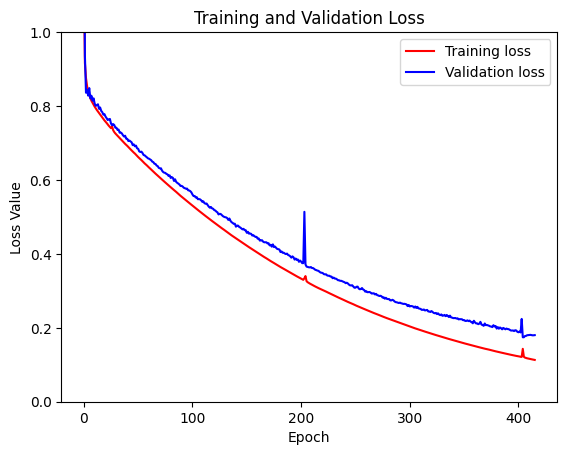

In [ ]:
# Plotting loss and validation loss
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(416)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

**Getting predictions**

In [ ]:
input_img_paths = sorted(
    [
        os.path.join(val_img_path, fname)
        for fname in os.listdir(val_img_path)
        if fname.endswith(".png")
    ]
)

target_img_paths = sorted(
    [
        os.path.join(val_mask_path, fname)
        for fname in os.listdir(val_mask_path)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)
print("Number of testing samples:", len(input_img_paths))

Number of testing samples: 19


In [ ]:
test_gen = OCT_test(batch_size, img_size, input_img_paths, target_img_paths)
test_preds = model.predict(test_gen)

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step


In [ ]:
print(np.shape(test_preds))

(16, 512, 256, 8)


**Visualazing predictions**

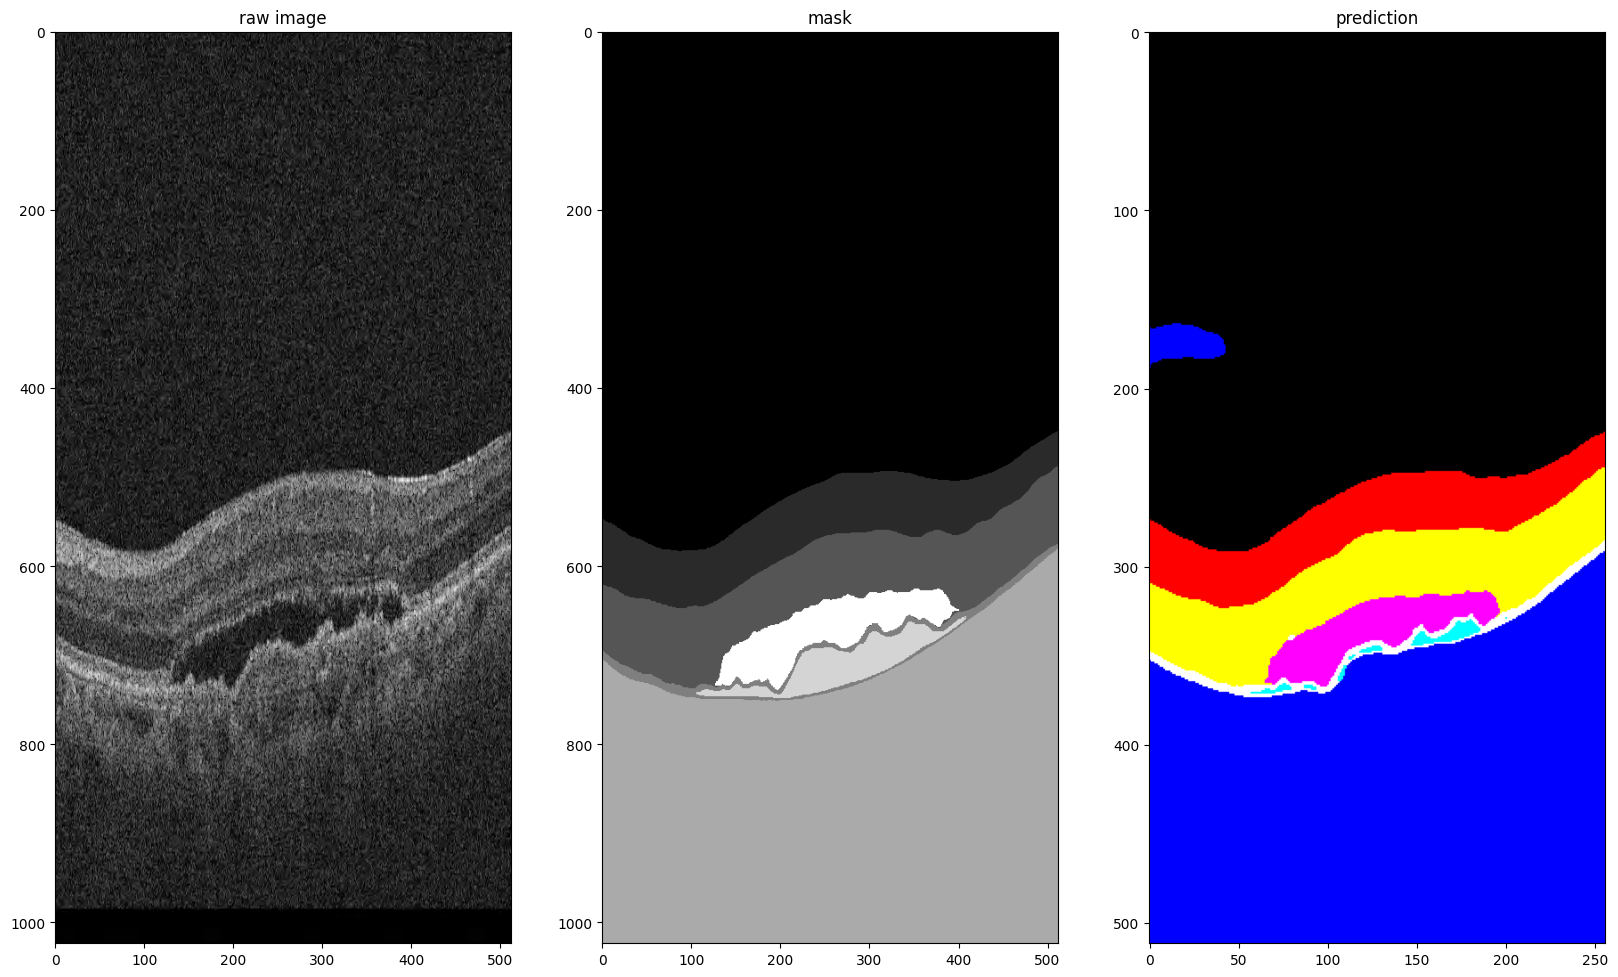

In [ ]:
m=os.listdir(val_img_path)
#i = np.random.randint(0,len(input_img_paths)-1)
i=11
plt.figure(figsize=(20, 20))

plt.subplot(1, 3, 1)
plt.title('raw image')
raw = PIL.ImageOps.autocontrast(load_img(input_img_paths[i]))
plt.imshow(raw)

plt.subplot(1, 3, 2)
plt.title('mask')
mask = PIL.ImageOps.autocontrast(load_img(target_img_paths[i]))
plt.imshow(mask)

plt.subplot(1, 3, 3)
plt.title('prediction')
pred = test_preds[i]
pred = np.argmax(pred, axis=-1)
pred = np.expand_dims(pred, axis=-1)
pred = num_to_colors(pred, IMG_HEIGHT, IMG_WIDTH)
plt.imshow(pred)



plt.show()


In [ ]:
print('Image id:', i ,  m[i])

Image id: 11 patient12_raw0060.png


## **Grad-CAM for pixel**

In [ ]:
def grad_cam_heatmap(model, img_tensor, class_index, target_layer_name):
    """
    Generate Grad-CAM heatmap for a given image tensor and class index.
    Args:
        model: Trained model.
        img_tensor: Preprocessed input image tensor (batch size = 1).
        class_index: Target class index.
        target_layer_name: Name of the target convolutional layer.
    Returns:
        heatmap: Grad-CAM heatmap (numpy array).
    """
    # Convert PIL Image to NumPy array before checking shape
    img_tensor = np.array(img_tensor)

    # Ensure input tensor is correctly shaped
    # Convert image to grayscale and resize before expanding dimensions
    img_tensor = tf.image.rgb_to_grayscale(img_tensor)
    img_tensor = tf.image.resize(img_tensor, (IMG_HEIGHT, IMG_WIDTH)) # Resize to match model input
    img_tensor = np.expand_dims(img_tensor, axis=0) # Add batch dimension
    # Define Grad-CAM model
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(target_layer_name).output, model.output]
    )

    # Forward pass and gradient computation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        tape.watch(conv_outputs)
        # Get the mask for the specific class
        loss = predictions[0, :, :, class_index]  # All pixels for the class

    grads = tape.gradient(loss, conv_outputs)
    # Compute the weights by global average pooling across the spatial dimensions
    weights = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Compute the Grad-CAM heatmap
    gradcam = tf.reduce_sum(tf.multiply(weights, conv_outputs[0]), axis=-1)
    gradcam = tf.maximum(gradcam, 0)  # Apply ReLU
    gradcam = gradcam.numpy()
    gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min())  # Normalize
    return gradcam


In [ ]:
def visualize_grad_cam_overlay(heatmap, original_image, alpha=0.4):
    """
    Overlay Grad-CAM heatmap on the original image.
    Args:
        heatmap: Grad-CAM heatmap (numpy array, normalized to [0, 1]).
        original_image: Original input image (grayscale).
        alpha: Blending factor for overlay.
    """
    # Rescale heatmap to 0-255 and apply colormap
    heatmap_rescaled = (heatmap * 255).astype(np.uint8)
    heatmap_colored = cv2.applyColorMap(heatmap_rescaled, cv2.COLORMAP_JET)

    original_image = np.array(original_image)  # Convert to NumPy array

    # Ensure original image is 3-channel
    if len(original_image.shape) == 2:  # Grayscale image
        original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)

    # Resize heatmap to match original image size
    heatmap_colored_resized = cv2.resize(heatmap_colored, (original_image.shape[1], original_image.shape[0]))

    # Overlay heatmap on the original image
    overlay = cv2.addWeighted(original_image, 1 - alpha, heatmap_colored_resized, alpha, 0)

    return overlay

<ipython-input-25-6d645c5eabc2>:41: RuntimeWarning: invalid value encountered in divide
  gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min())  # Normalize
<ipython-input-27-0730cd399ec2>:10: RuntimeWarning: invalid value encountered in cast
  heatmap_rescaled = (heatmap * 255).astype(np.uint8)


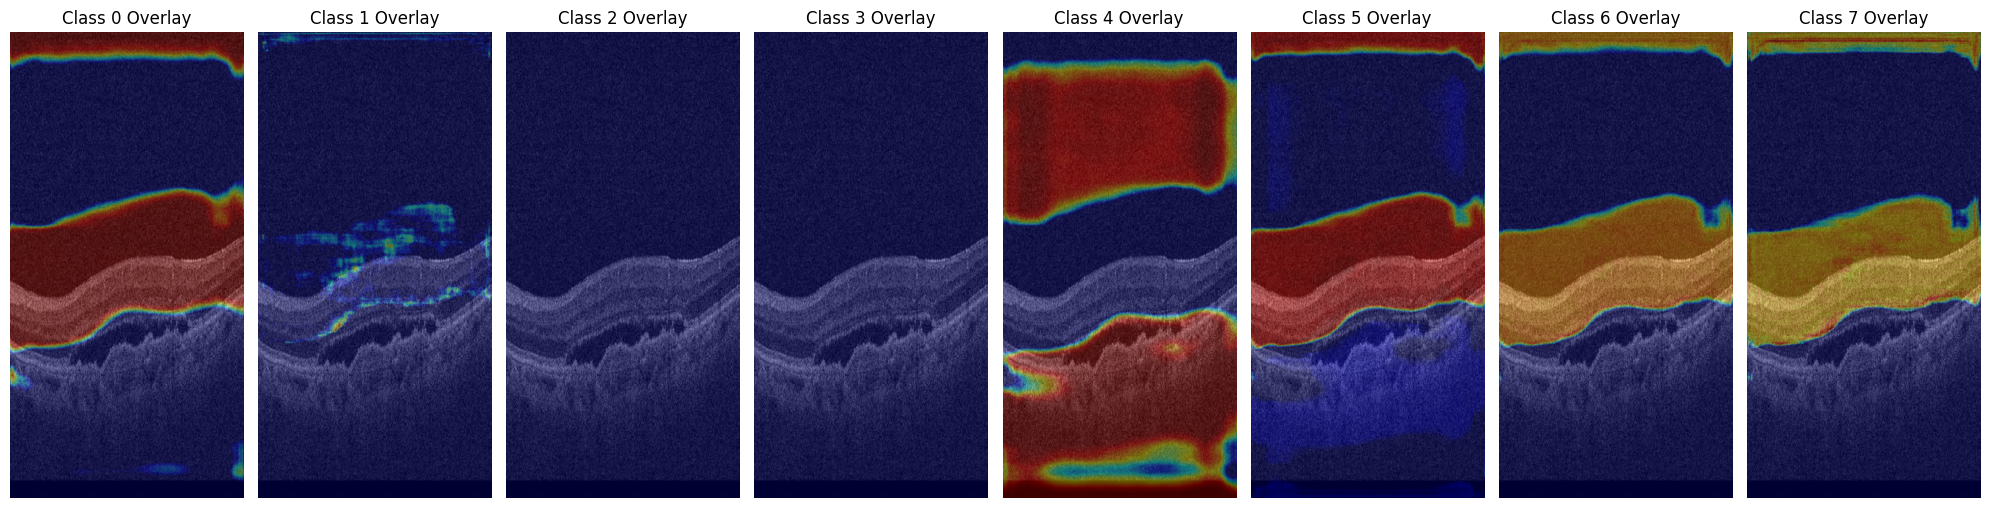

In [ ]:
target_layer_name= "conv2d_38"
num_classes = 8
fig, axes = plt.subplots(1, 8, figsize=(20, 10))
axes = axes.flatten()  # Flatten axes for easier iteration
img_tensor = raw
for class_index in range(num_classes):
      heatmap = grad_cam_heatmap(model, img_tensor, class_index, target_layer_name)
      overlay = visualize_grad_cam_overlay(heatmap, raw)
      axes[class_index].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
      axes[class_index].set_title(f"Class {class_index} Overlay")
      axes[class_index].axis("off")
plt.tight_layout()
plt.show()


## **multiple layer heatmap with weights**

In [ ]:
def grad_cam(model, img_tensor, class_index, layer_name):
    """
    Generate Grad-CAM heatmap for a given class and layer.

    Args:
        model: Keras model.
        img_tensor: Input tensor (preprocessed image with shape (1, H, W, C)).
        class_index: Target class index.
        layer_name: Name of the target convolutional layer.

    Returns:
        heatmap: Grad-CAM heatmap (H, W).
    """
    # Convert PIL Image to NumPy array before checking shape
    img_tensor = np.array(img_tensor)

    # Ensure input tensor is correctly shaped
    # Convert image to grayscale and resize before expanding dimensions
    img_tensor = tf.image.rgb_to_grayscale(img_tensor)
    img_tensor = tf.image.resize(img_tensor, (IMG_HEIGHT, IMG_WIDTH)) # Resize to match model input
    img_tensor = np.expand_dims(img_tensor, axis=0) # Add batch dimension
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        loss = tf.reduce_mean(predictions[..., class_index])  # Target class loss

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Compute weighted sum of feature maps
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.nn.relu(heatmap).numpy()

    # Normalize heatmap
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap) + 1e-7)

    return heatmap

In [ ]:
def visualize_weighted_combined_grad_cam(model, img_tensor, raw_image, num_classes, layer_names, layer_weights):
    """
    Visualize weighted combined Grad-CAM heatmaps from multiple layers for all classes.

    Args:
        model: Keras model.
        img_tensor: Input tensor (preprocessed image with shape (1, H, W, C)).
        raw_image: Original raw image for overlay (must be normalized to [0, 1]).
        num_classes: Number of classes in the model.
        layer_names: List of convolutional layers for Grad-CAM.
        layer_weights: List of weights corresponding to each layer in layer_names.
    """
    # Normalize raw image to [0, 1] if not already
    raw_image_normalized = raw_image / 255.0 if raw_image.max() > 1 else raw_image

    fig, axes = plt.subplots(1, num_classes, figsize=(20, 10))

    for class_index in range(num_classes):
        # Initialize aggregated heatmap
        combined_heatmap = None

        for layer_name, weight in zip(layer_names, layer_weights):
            # Compute Grad-CAM heatmap for the layer
            heatmap = grad_cam(model, img_tensor, class_index, layer_name)

            # Resize heatmap to match raw image size
            heatmap_resized = tf.image.resize(
                heatmap[..., np.newaxis],  # Add channel dimension
                (raw_image_normalized.shape[0], raw_image_normalized.shape[1]),
                method='bilinear'
            ).numpy().squeeze()  # Remove channel dimension

            # Aggregate heatmaps with weights
            if combined_heatmap is None:
                combined_heatmap = weight * heatmap_resized
            else:
                combined_heatmap += weight * heatmap_resized

        # Normalize combined heatmap
        combined_heatmap = (combined_heatmap - np.min(combined_heatmap)) / \
                           (np.max(combined_heatmap) - np.min(combined_heatmap) + 1e-7)

        # Create RGB heatmap
        heatmap_colored = plt.cm.jet(combined_heatmap)[:, :, :3]  # Convert heatmap to RGB

        # Overlay heatmap on raw image
        overlay = np.clip(raw_image_normalized * 0.5 + heatmap_colored * 0.5, 0, 1)

        axes[class_index].imshow(overlay)
        axes[class_index].set_title(f"Class {class_index} Overlay")
        axes[class_index].axis("off")

    plt.tight_layout()
    plt.show()
    return heatmap_colored

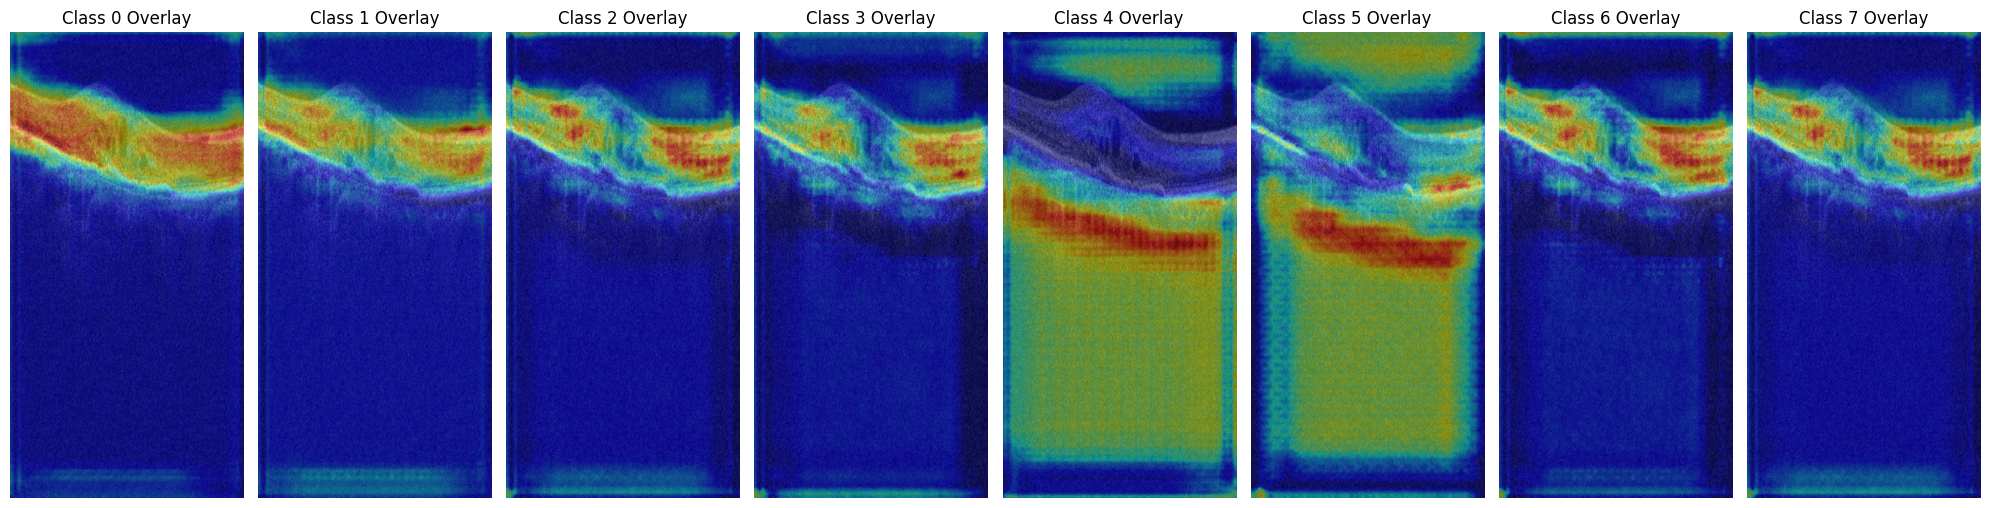

array([[[0.        , 0.69215686, 1.        ],
        [0.        , 0.69215686, 1.        ],
        [0.        , 0.69215686, 1.        ],
        ...,
        [0.        , 0.37843137, 1.        ],
        [0.        , 0.37843137, 1.        ],
        [0.        , 0.37843137, 1.        ]],

       [[0.        , 0.69215686, 1.        ],
        [0.        , 0.69215686, 1.        ],
        [0.        , 0.69215686, 1.        ],
        ...,
        [0.        , 0.37843137, 1.        ],
        [0.        , 0.37843137, 1.        ],
        [0.        , 0.37843137, 1.        ]],

       [[0.        , 0.69215686, 1.        ],
        [0.        , 0.69215686, 1.        ],
        [0.        , 0.69215686, 1.        ],
        ...,
        [0.        , 0.37843137, 1.        ],
        [0.        , 0.37843137, 1.        ],
        [0.        , 0.37843137, 1.        ]],

       ...,

       [[0.3257432 , 1.        , 0.64199873],
        [0.3257432 , 1.        , 0.64199873],
        [0.3257432 , 1

In [ ]:
raw_image = np.array(raw) # Convert raw to NumPy array
img_tensor = raw
layer_names = ["conv2d_5", "conv2d_7", "conv2d_9", "conv2d_13", "conv2d_17"]
layer_weights = [0.2, 0.2, 0.2, 0.2, 0.2]
visualize_weighted_combined_grad_cam(model, img_tensor, raw_image, num_classes=8, layer_names=layer_names, layer_weights=layer_weights)

In [ ]:
img_tensor = raw
class_index = 0
target_layer_name = "conv2d_17"
heatmap = grad_cam_heatmap(model, img_tensor, class_index, target_layer_name)

In [ ]:
print(np.shape(heatmap))
print(np.shape(pred))
print(np.shape(raw))
print(np.shape(mask))
print(pred[1])

(512, 256)
(512, 256, 4)
(1024, 512, 3)
(1024, 512, 3)
[[  0.   0.   0. 255.]
 [  0.   0.   0. 255.]
 [  0.   0.   0. 255.]
 ...
 [  0.   0.   0. 255.]
 [  0.   0.   0. 255.]
 [  0.   0.   0. 255.]]


# **Heatmas alignment evaluation**

**Weighted Overlap**

In [ ]:
def weighted_overlap(heatmaps, mask, num_classes):
    """
    Compute the Weighted Overlap metric for a single image.

    Args:
        heatmaps (numpy.ndarray): Array of shape (H, W, num_classes) containing heatmaps for each class.
        mask (numpy.ndarray): Ground truth mask of shape (H, W) with class labels (0 to num_classes-1).
        num_classes (int): Total number of classes.

    Returns:
        dict: Weighted Overlap score for each class.
    """
    weighted_overlap_scores = {}

    for class_idx in range(num_classes):
        # Create a binary mask for the current class
        binary_mask = (mask == class_idx).astype(float)

        # Extract the heatmap for the current class
        heatmap = heatmaps[:, :, class_idx]

        # Compute the numerator: sum of heatmap values weighted by the binary mask
        numerator = np.sum(heatmap * binary_mask)

        # Compute the denominator: total sum of the heatmap values
        denominator = np.sum(heatmap) + 1e-10  # Avoid division by zero

        # Compute Weighted Overlap
        weighted_overlap_scores[class_idx] = numerator / denominator

    return weighted_overlap_scores


In [ ]:
H, W, num_classes = 512, 256, 8
num_images = 16
target_layer_name = "conv2d_37"
cumulative_scores = {class_idx: 0 for class_idx in range(num_classes)} # Initialize with keys 0 to num_classes - 1
for i in range(num_images):
  raw = load_img(input_img_paths[i])
  img_tensor = raw
  mask = load_img(target_img_paths[i], target_size = img_size, color_mode="grayscale")
  mask = np.reshape(mask, (IMG_HEIGHT, IMG_WIDTH))
  heatmaps = np.zeros((H, W, num_classes))
  for class_idx in range(num_classes):
    heatmap = grad_cam_heatmap(model, img_tensor, class_idx, target_layer_name)
    heatmaps[:, :, class_idx] = heatmap
  scores = weighted_overlap(heatmaps, mask, num_classes)
  for class_idx, score in scores.items():
        cumulative_scores[class_idx] += score

# Compute the average scores
average_scores = {class_idx: cumulative_scores[class_idx] / num_images for class_idx in range(num_classes)}
for class_idx, score in average_scores.items():
      print(f"Class {class_idx}: Weighted Overlap = {score:.4f}")



Class 0: Weighted Overlap = 0.5193
Class 1: Weighted Overlap = 0.0975
Class 2: Weighted Overlap = 0.0865
Class 3: Weighted Overlap = 0.0075
Class 4: Weighted Overlap = 0.9798
Class 5: Weighted Overlap = 0.0028
Class 6: Weighted Overlap = 0.0007
Class 7: Weighted Overlap = 0.0031


In [ ]:
H, W, num_classes = 512, 256, 8
num_images = 16
target_layer_name = "conv2d_37"
cumulative_scores = {class_idx: 0 for class_idx in range(num_classes)} # Initialize with keys 0 to num_classes - 1
for i in range(num_images):
  raw = load_img(input_img_paths[i])
  img_tensor = raw
  pred = test_preds[i]
  pred = np.argmax(pred, axis=-1)
  heatmaps = np.zeros((H, W, num_classes))
  for class_idx in range(num_classes):
    heatmap = grad_cam_heatmap(model, img_tensor, class_idx, target_layer_name)
    heatmaps[:, :, class_idx] = heatmap
  scores = weighted_overlap(heatmaps, pred, num_classes)
  for class_idx, score in scores.items():
        cumulative_scores[class_idx] += score

# Compute the average scores
average_scores = {class_idx: cumulative_scores[class_idx] / num_images for class_idx in range(num_classes)}
for class_idx, score in average_scores.items():
      print(f"Class {class_idx}: Weighted Overlap = {score:.4f}")

Class 0: Weighted Overlap = 0.5181
Class 1: Weighted Overlap = 0.0975
Class 2: Weighted Overlap = 0.0873
Class 3: Weighted Overlap = 0.0084
Class 4: Weighted Overlap = 0.9579
Class 5: Weighted Overlap = 0.0027
Class 6: Weighted Overlap = 0.0009
Class 7: Weighted Overlap = 0.0020


# **Segmentation evaluation**

**Confusion matrix**

In [ ]:
i= 0

mask = load_img(target_img_paths[i], target_size = img_size, color_mode="grayscale")
mask = np.reshape(mask, (IMG_HEIGHT, IMG_WIDTH, 1))

pred = np.argmax(test_preds[i], axis=-1)
pred = np.expand_dims(pred, axis=-1)
print(np.shape(pred))



pred_vector=pred.flatten()
mask_vector=mask.flatten()


# i range from 1 to number of images in val (test) set
for i in range(1, 32):
  mask = load_img(target_img_paths[i], target_size = img_size, color_mode="grayscale")
  mask = np.reshape(mask, (IMG_HEIGHT, IMG_WIDTH, 1))
  mask_vector = np.concatenate((mask_vector, mask.flatten()), axis=0)
  pred = np.argmax(test_preds[i], axis=-1)
  pred = np.expand_dims(pred, axis=-1)
  pred_vector = np.concatenate((pred_vector, pred.flatten()), axis=0)

(512, 256, 1)


IndexError: index 16 is out of bounds for axis 0 with size 16

In [ ]:
print(np.shape(mask_vector))
print(np.shape(pred_vector))

(4194304,)
(4194304,)


1. sklearn

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(mask_vector, pred_vector)

In [ ]:
print(cf_matrix)

[[1088045    3640       0       0       0       0       0       0]
 [    608  208959    6354       0       0       0       0       0]
 [      0    9683  379513   23007      10      85    2923       0]
 [      0       0    1575   28469    9833    1655    1299       4]
 [   3042       0       0    2488 2381793     359       0       0]
 [      7       0     175     623       0   14768   11554   13774]
 [      0       0       8       0       0       0      51       0]
 [      0       0       0       0       0       0       0       0]]


In [ ]:
cf_matrix_normal = cf_matrix.astype('float32') / cf_matrix.sum(axis=1)[:, np.newaxis]
print(cf_matrix_normal )

[[9.96665705e-01 3.33429515e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.81584468e-03 9.67756726e-01 2.94274295e-02 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.33201115e-02 9.14002423e-01 5.54090472e-02
  2.40835603e-05 2.04710263e-04 7.03962468e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.67689973e-02 6.64620054e-01
  2.29555270e-01 3.86366289e-02 3.03256683e-02 9.33815805e-05]
 [1.27403901e-03 0.00000000e+00 0.00000000e+00 1.04201481e-03
  9.97533591e-01 1.50355031e-04 0.00000000e+00 0.00000000e+00]
 [1.71144960e-04 0.00000000e+00 4.27862399e-03 1.52319014e-02
  0.00000000e+00 3.61066967e-01 2.82486981e-01 3.36764382e-01]
 [0.00000000e+00 0.00000000e+00 1.35593220e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00 8.64406780e-01 0.00000000e+00]
 [           nan            nan            nan            nan
             nan            nan            nan            nan]]

<ipython-input-61-ca3a7227cb26>:1: RuntimeWarning: invalid value encountered in divide
  cf_matrix_normal = cf_matrix.astype('float32') / cf_matrix.sum(axis=1)[:, np.newaxis]


In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.2f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

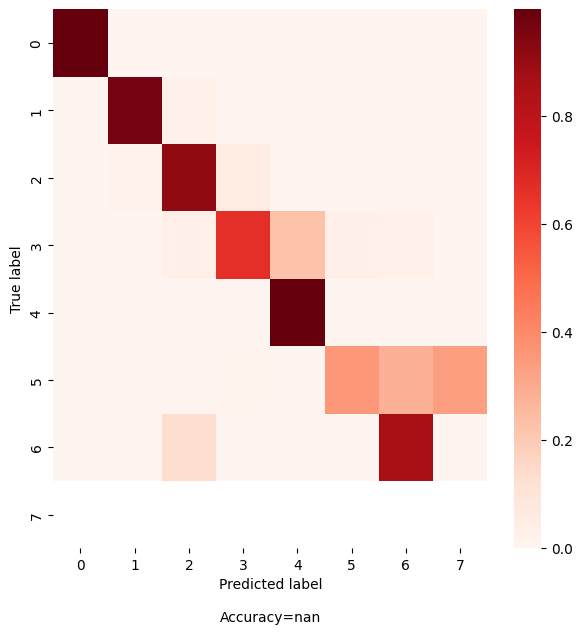

In [ ]:
make_confusion_matrix(cf_matrix_normal, count = False, percent = False, figsize=(7,7), cbar=True, cmap='Reds')

In [ ]:
#cf_matrix_normal = (cm1+cm2+cm3+cm4+cm5+cm6)/6

2. pycm

In [ ]:
!pip install pycm

In [ ]:
import pycm
from pycm import *

In [ ]:
cm = ConfusionMatrix(actual_vector=mask_vector, predict_vector=pred_vector)
cm.classes

[0, 1, 2, 3, 4, 5, 6, 7]

In [ ]:
print(cm)

Predict       0             1             2             3             4             5             6             7             
Actual
0             1088045       3640          0             0             0             0             0             0             

1             608           208959        6354          0             0             0             0             0             

2             0             9683          379513        23007         10            85            2923          0             

3             0             0             1575          28469         9833          1655          1299          4             

4             3042          0             0             2488          2381793       359           0             0             

5             7             0             175           623           0             14768         11554         13774         

6             0             0             8             0             0             0             